# AIAP Foundation Self Practice

The objective is to predict the students' O-level mathematics examination score to help the school to identify weaker students prior to the examination using the dataset provided. In your submission, you should evaluate at least 3 suitable models for estimating the students' scores.

## Data Dictionary

| Column               | Description                        |
| -------------------- | ---------------------------------- |
| student_id           | Unique ID for each student         |
| number_of_siblings   | Number of siblings                 |
| direct_admission     | Mode of entering the school        |
| CCA                  | Enrolled CCA                       |
| learning_style       | Primary learning style             |
| tuition              | Indication of whether the student has a tuition   |
| final_test           | Student's O-level mathematics examination score   |
| n_male               | Number of male classmates          |
| n_female             | Number of female classmates        |
| gender               | Gender type                        |
| age                  | Age of the student                 |
| hours_per_week       | Number of hours student studies per week          |
| attendance_rate      | Attendance rate of the student (%) |
| sleep_time           | Daily sleeping time (hour:minutes) |
| wake_time            | Daily waking up time (hour:minutes)               |
| mode_of_transport    | Mode of transport to school        |
| bag_color            | Colours of student's bag           |

<br>
<hr>

## Exploratory Data Analysis

### Load libraries

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import pprint
from pathlib import Path

### Setting notebook settings

In [2]:
# Setting Jupyter notebook settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 999)

In [3]:
# Setting global variables for dataset path and path to save plots and graphs
FILE_PATH = "./data/regression_bonus_practice_data.csv"
PLOT_PATH = "./images/"

### Load data

In [4]:
# Load the dataset: first check the file exists and stop execution with a clear message if not.
file_path_obj = Path(FILE_PATH)
if not file_path_obj.is_file():
    print(f"File not found at: {FILE_PATH}")
    # print("Please check the FILE_PATH variable or place the CSV at the expected location.")
    print("Exiting program.")
    sys.exit(1)
# If the file exists, read it into a DataFrame and show the dataset's dimensions.
df = pd.read_csv(FILE_PATH)
print(f"Dataset loaded: {df.shape[0]:,} rows by {df.shape[1]:,} columns.")

Dataset loaded: 15,900 rows by 18 columns.


### Checking dataset structure

In [5]:
# Displaying the dataset structure and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15900 entries, 0 to 15899
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               15900 non-null  int64  
 1   number_of_siblings  15900 non-null  int64  
 2   direct_admission    15900 non-null  object 
 3   CCA                 12071 non-null  object 
 4   learning_style      15900 non-null  object 
 5   student_id          15900 non-null  object 
 6   gender              15900 non-null  object 
 7   tuition             15900 non-null  object 
 8   final_test          15405 non-null  float64
 9   n_male              15900 non-null  float64
 10  n_female            15900 non-null  float64
 11  age                 15900 non-null  float64
 12  hours_per_week      15900 non-null  float64
 13  attendance_rate     15122 non-null  float64
 14  sleep_time          15900 non-null  object 
 15  wake_time           15900 non-null  object 
 16  mode

### Checking for missing values

In [6]:
# Identify columns with missing data
missing_counts = df.isnull().sum()
missing_percent = df.isnull().mean() * 100

# Filter columns with missing values
missing_columns = missing_counts[missing_counts > 0].index.tolist()

# Display columns with missing values, their count, and percentage
print("Columns with missing data:\n")
for col in missing_columns:
    print(f"{col:<25} : {missing_counts[col]:>6,} missing ({missing_percent[col]:>5.2f}%)")

Columns with missing data:

CCA                       :  3,829 missing (24.08%)
final_test                :    495 missing ( 3.11%)
attendance_rate           :    778 missing ( 4.89%)


### Checking numerical columns statistics

In [7]:
# Displaying transposed output of numerical columns statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,15900.0,7949.500000,4590.078975,0.0,3974.75,7949.5,11924.25,15899.0
number_of_siblings,15900.0,0.886541,0.751346,0.0,0.00,1.0,1.00,2.0
final_test,15405.0,67.165401,13.977879,32.0,56.00,68.0,78.00,100.0
n_male,15900.0,13.880000,6.552584,0.0,10.00,14.0,18.00,31.0
n_female,15900.0,8.906038,6.663852,0.0,4.00,8.0,13.00,31.0
age,15900.0,15.213459,1.758941,-5.0,15.00,15.0,16.00,16.0
hours_per_week,15900.0,10.312579,4.461861,0.0,7.00,9.0,14.00,20.0
attendance_rate,15122.0,93.270268,7.984230,40.0,92.00,95.0,97.00,100.0


### Checking for duplicates

In [8]:
# Checking for duplicates
if df.duplicated().sum() == 0:
    print('There are no duplicates in the dataset.')
else:
    #
    print('There are duplicates found in the dataset.')
    print(f"There are a total of {len(df.duplcated().sum)} duplicates.")
    print('Recommend dropping the duplicates.')

There are no duplicates in the dataset.


### Checking non-numerical columns statistixs

In [9]:
# Checking object type columns
# df.select_dtypes(include = 'object').value_counts()
value_counts_dict = {col: df[col].value_counts() for col in df.select_dtypes(include='object').columns}

print('Breakdown of the frequency of values in the object data type.')
print('-' * 60)
pprint.pprint(value_counts_dict)


Breakdown of the frequency of values in the object data type.
------------------------------------------------------------
{'CCA': CCA
Clubs     3912
Sports    3865
Arts      3785
CLUBS      143
NONE       130
ARTS       128
SPORTS     108
Name: count, dtype: int64,
 'bag_color': bag_color
yellow    2731
green     2653
black     2650
blue      2634
red       2620
white     2612
Name: count, dtype: int64,
 'direct_admission': direct_admission
No     11195
Yes     4705
Name: count, dtype: int64,
 'gender': gender
Male      7984
Female    7916
Name: count, dtype: int64,
 'learning_style': learning_style
Auditory    9132
Visual      6768
Name: count, dtype: int64,
 'mode_of_transport': mode_of_transport
public transport     6371
private transport    6323
walk                 3206
Name: count, dtype: int64,
 'sleep_time': sleep_time
23:00    3131
22:00    3067
22:30    3034
21:00    2953
21:30    2875
0:00      240
23:30     183
1:00      122
0:30       93
2:00       81
1:30       73
2:30  

## Data Cleaning

### Cleaning `CCA` column

In [10]:
# Displaying the breakdown of the CCA activities students have joined
display(df['CCA'].value_counts())

print(f"Total missing values in the column: {df['CCA'].isna().sum():,}")

CCA
Clubs     3912
Sports    3865
Arts      3785
CLUBS      143
NONE       130
ARTS       128
SPORTS     108
Name: count, dtype: int64

Total missing values in the column: 3,829


As there are duplicates in the CCA values, we need to standardize on the values but converting them to upper case.

Also, as there are missing values in the column, it will be set to 'NONE'.

In [11]:
# Converting all values to uppercase
df['CCA'] = df['CCA'].str.upper()

# Filling the missing values with the 'NONE' category
df['CCA'] = df['CCA'].fillna('NONE')

# Display the breakdown again
display(df['CCA'].value_counts())

CCA
CLUBS     4055
SPORTS    3973
NONE      3959
ARTS      3913
Name: count, dtype: int64

### Creating sleep duration column

The 2 columns - **sleep_time** and **wake_time** - seem to be stgoring the times the students sleep and awake for school. in HH:MM format. These 2 columns will be converted into datetime formaats. Then, an arithmatic operation will be performed to calculate the sleep duration of the student. Then, it will be converted into minutes.

In [12]:
# Convert the 2 string columns to datetime objects
df['sleep_time_dt'] = pd.to_datetime(df['sleep_time'], format='%H:%M')
df['wake_time_dt'] = pd.to_datetime(df['wake_time'], format='%H:%M')

# Calculate the duration, not forgetting to handle the overnight timings
duration = np.where(
    df['wake_time_dt'] < df['sleep_time_dt'],
    # If wake time is "before" sleep time, add a day to wake time
    df['wake_time_dt'] + pd.Timedelta(days=1) - df['sleep_time_dt'],
    # Otherwise, it's a simple subtraction
    df['wake_time_dt'] - df['sleep_time_dt']
)
df['sleep_duration'] = duration

# Convert the duration (Timedelta) to total minutes
df['sleep_minutes'] = (df['sleep_duration'].dt.total_seconds() / 60).astype(int)

# Display the column breakdown
display(df['sleep_minutes'].describe())

count    15900.000000
mean       470.788679
std         36.140028
min        240.000000
25%        480.000000
50%        480.000000
75%        480.000000
max        480.000000
Name: sleep_minutes, dtype: float64

In [13]:
# Display the sleep minutes frequency breakdown
df['sleep_minutes'].value_counts()

sleep_minutes
480    14621
420      654
360      240
300      233
240      152
Name: count, dtype: int64

On the whole, more than 90% of students sleep at least 8 hours of sleep. in fact about 2.4% of the students do not get sufficient sleep, and they sleep at least 5 hours. Will need to investigate if sleep time impacts a student's final test result.

### Cleaning `tuition` column

In [14]:
df['tuition'].value_counts()

tuition
Yes    8669
No     6643
Y       327
N       261
Name: count, dtype: int64

There are inconsistencies in the values encoded into this column. There are 4 values for whether a sudent receives tuition or not. As such, we will standardize the encoding to only 2 values - 'Y' and 'N'. 

We will need to check if a model can differentiate if the student receiving higher marks received tuition.

In [15]:
# Create replacement mapping values
tuition_replacement_code = {'Yes': 'Y', 
                            'No': 'N'
                            }
# Perform the replacement operationg
df['tuition'] = df['tuition'].replace(tuition_replacement_code)

# Verify that the replacement is successful
df['tuition'].value_counts()

tuition
Y    8996
N    6904
Name: count, dtype: int64

### Filling up missing values in `attendance_rate`

In [16]:
display(df['attendance_rate'].describe())

print(f"Total number of missing values: {df['attendance_rate'].isna().sum():,}")
# print(len(df['attendance_rate'].isna().sum()))

count    15122.000000
mean        93.270268
std          7.984230
min         40.000000
25%         92.000000
50%         95.000000
75%         97.000000
max        100.000000
Name: attendance_rate, dtype: float64

Total number of missing values: 778


As there are missing values in this column, about 778 observations, or 4.48%, we will use the median value of this column, which is at 95%.

In [17]:
# Calculate the median value of the attendance_rate column
attendance_rate_median = df['attendance_rate'].median()

# Assign the missing values with the calculated median 
df['attendance_rate'] = df['attendance_rate'].fillna(attendance_rate_median)
print('Missing values in attendance rate has been replaced with the median.')

# df['attendance_rate'].describe()

# Checking if ther are any empty values in the CCQ column
if df['attendance_rate'].isna().sum() == 0:
    print('There are no more empty values.')
else:
    print('NOTE: There are still missing values in the column.')
    print('This requires your attention')
    sys.exit(1)    

Missing values in attendance rate has been replaced with the median.
There are no more empty values.


### Cleaning `final_test` column

This column has missing values, and will also be replaced with the median value.

In [18]:
# Calculating the median value of the 'final_test' column
final_test_median = df['final_test'].median()
print(f"The median value of the column {final_test_median}")

# Replacing the missing value with the median value
df['final_test'].fillna(final_test_median, inplace = True)

The median value of the column 68.0


The missing value in the `final_test` column has been replaced with the median value of the column, which is 68.0.

### Checking `age` distribution

In [19]:
df['age'].describe()

count    15900.000000
mean        15.213459
std          1.758941
min         -5.000000
25%         15.000000
50%         15.000000
75%         16.000000
max         16.000000
Name: age, dtype: float64

In [20]:
df['age'].value_counts()

age
 15.0    7726
 16.0    7723
 6.0      230
 5.0      216
-5.0        4
-4.0        1
Name: count, dtype: int64

From the frequency table above, there are several erroneous values in the `age` column. Thus, I would perform the following operations to rectify the problem:

1. Take the absolute value of their ages.
2. Create a replacement age map so that single digit values are converted into the teens (i.e., 14, 15, 16)
3. Instead of leaving the single value of '14' as a standalone age value, I will change it to 15, as most students who sit for the 'O' level examinations are usually in their 15s and 16s. 

In [21]:
df['age'] = df['age'].abs()

age_replacement_map = {4: 15,
                       5: 15,
                       6: 16
                       }

# Perform the replacement operationg
df['age'] = df['age'].replace(age_replacement_map)

# Verify that the replacement is successful
df['age'].value_counts()

age
16.0    7953
15.0    7947
Name: count, dtype: int64

### Checking if missing value still persists

In [22]:
# print(df.isnull().sum().sum())

if df.isnull().sum().sum() == 0:
    print('All missing values have been treated.')
else:
    print('There are still missing values in the dataset')
    sys.exit(1)

All missing values have been treated.


In [23]:
# Displaying the top 10 records of the post-cleaning
df.head(10)

,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color,sleep_time_dt,wake_time_dt,sleep_duration,sleep_minutes
0,0,0,Yes,SPORTS,Visual,ACN2BE,Female,N,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow,1900-01-01 22:00:00,1900-01-01 06:00:00,0 days 08:00:00,480
1,1,2,No,SPORTS,Auditory,FGXIIZ,Female,N,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green,1900-01-01 22:30:00,1900-01-01 06:30:00,0 days 08:00:00,480
2,2,0,Yes,NONE,Visual,B9AI9F,Male,N,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white,1900-01-01 22:30:00,1900-01-01 06:30:00,0 days 08:00:00,480
3,3,1,No,CLUBS,Auditory,FEVM1T,Female,Y,64.0,2.0,20.0,15.0,18.0,95.0,21:00,5:00,public transport,yellow,1900-01-01 21:00:00,1900-01-01 05:00:00,0 days 08:00:00,480
4,4,0,No,SPORTS,Auditory,AXZN2E,Male,N,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow,1900-01-01 21:30:00,1900-01-01 05:30:00,0 days 08:00:00,480
5,5,0,No,ARTS,Visual,BA6R14,Female,N,57.0,9.0,12.0,15.0,11.0,96.0,22:30,6:30,private transport,red,1900-01-01 22:30:00,1900-01-01 06:30:00,0 days 08:00:00,480
6,6,2,Yes,NONE,Visual,D5WGTI,Male,N,69.0,12.0,3.0,16.0,15.0,93.0,21:30,5:30,public transport,green,1900-01-01 21:30:00,1900-01-01 05:30:00,0 days 08:00:00,480
7,7,0,No,SPORTS,Visual,HTP8CW,Male,N,76.0,20.0,2.0,15.0,3.0,97.0,21:00,5:00,public transport,green,1900-01-01 21:00:00,1900-01-01 05:00:00,0 days 08:00:00,480
8,8,0,No,ARTS,Auditory,U3YRTC,Male,N,57.0,20.0,7.0,15.0,15.0,98.0,22:00,6:00,private transport,red,1900-01-01 22:00:00,1900-01-01 06:00:00,0 days 08:00:00,480
9,9,2,No,ARTS,Auditory,3MOMA6,Male,Y,60.0,13.0,9.0,16.0,16.0,95.0,22:30,6:30,private transport,green,1900-01-01 22:30:00,1900-01-01 06:30:00,0 days 08:00:00,480


### Saving a clean copy

In [24]:
# df_null_score = df[df['final_test'].isnull()]

# df.dropna(inplace = True)

# Creating a duplicate copy of the dataset post cleanup
df_cleaned = df.copy(deep = True)

df_cleaned.to_csv('./data/cleaned_data.csv')

### Dropping non-essential columns

In [25]:
# Removing non-essential colukns
df.drop(columns = ['index', 'student_id', 'sleep_time', 'wake_time', 'sleep_time_dt', 'wake_time_dt', 'sleep_duration'],
        inplace = True)

### Checking cleaned data structure

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15900 entries, 0 to 15899
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   number_of_siblings  15900 non-null  int64  
 1   direct_admission    15900 non-null  object 
 2   CCA                 15900 non-null  object 
 3   learning_style      15900 non-null  object 
 4   gender              15900 non-null  object 
 5   tuition             15900 non-null  object 
 6   final_test          15900 non-null  float64
 7   n_male              15900 non-null  float64
 8   n_female            15900 non-null  float64
 9   age                 15900 non-null  float64
 10  hours_per_week      15900 non-null  float64
 11  attendance_rate     15900 non-null  float64
 12  mode_of_transport   15900 non-null  object 
 13  bag_color           15900 non-null  object 
 14  sleep_minutes       15900 non-null  int64  
dtypes: float64(6), int64(2), object(7)
memory usage: 1.8+

In [27]:
df.duplicated().sum()

np.int64(140)

## Univariate analysis

### Pie Charts

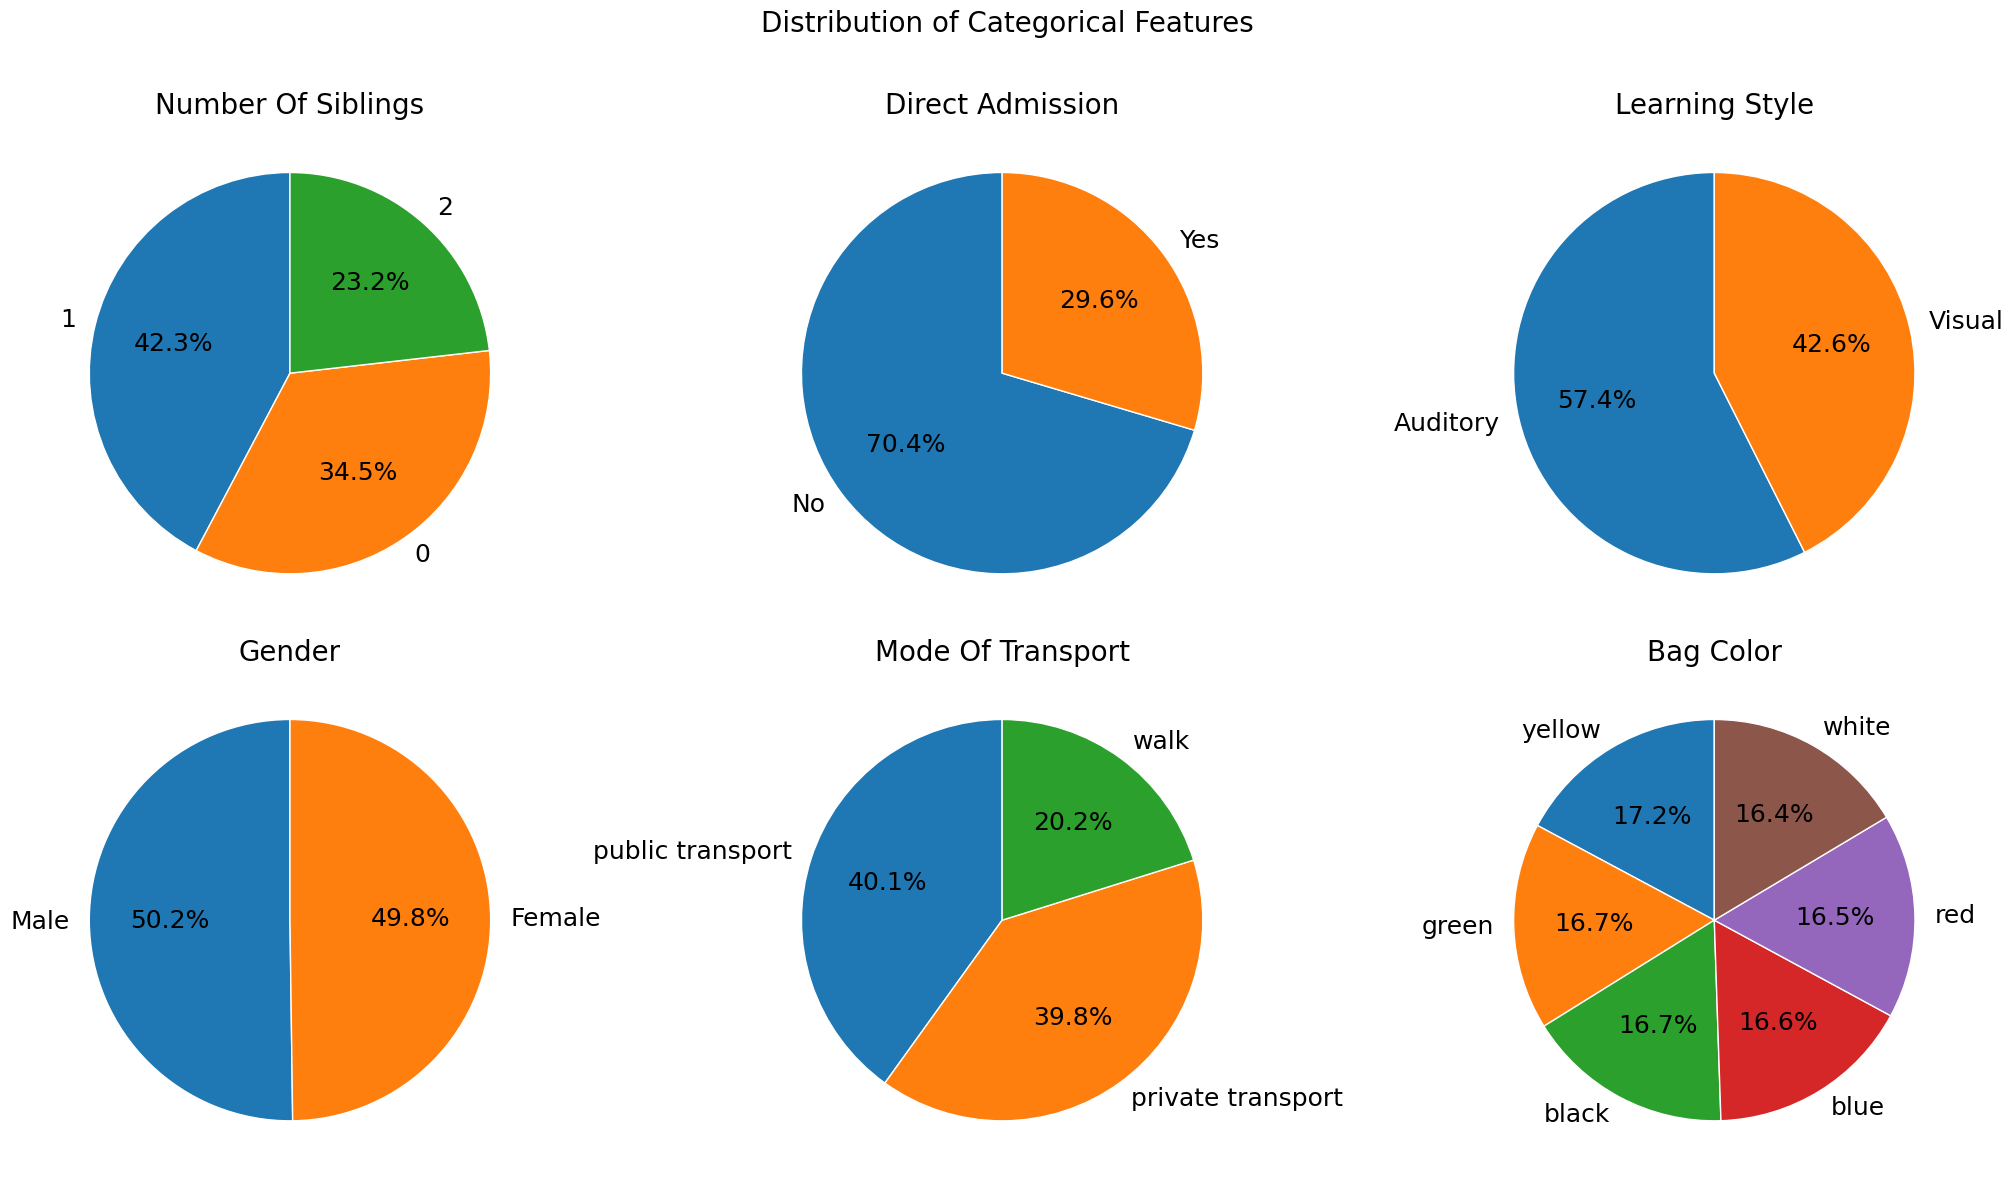

In [28]:
# Creating a list of columns
columns_to_plot = [
    'number_of_siblings', 'direct_admission', 'learning_style', 
    'gender', 'mode_of_transport', 'bag_color'
]

# Create a figure and a set of subplots, a 2x3 grid of pie charts
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
fig.suptitle('Distribution of Categorical Features', fontsize=20)

# Flatten the axes array to make it easy to loop over
axes = axes.flatten()

# Loop through columns and plot on each subplot
for i, column in enumerate(columns_to_plot):
    value_counts = df[column].value_counts()
    ax = axes[i] # Select the subplot
    
    ax.pie(
        value_counts, 
        labels=value_counts.index, 
        autopct='%1.1f%%', 
        startangle=90,
        # Add some styling for a cleaner look
        wedgeprops={'edgecolor': 'white'},
        textprops={'fontsize': 18} 
    )
    ax.set_title(f'{column.replace("_", " ").title()}', fontsize = 20)

# If you have an odd number of plots, you might want to hide the last empty one
# for i in range(len(columns_to_plot), len(axes)):
#     fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for the suptitle
plt.savefig(PLOT_PATH + "pie_charts_6.png")
plt.show()

#### Analysis notes

- **Number of siblings**: 42.2% of the observations in the cleaned dataset haws 1 other siblings, followed by 34.6% has no other siblings, while 23.3% has 2 siblings. It is possible that having siblings may lead to a higher test scores.
- **Direct admission**: Nearly 3/4, or exactly 70.5% of the students did not get admitted directly.
- **Learning style**: 57.4% of students learn through auditory methods, which means they acquire retain knowledge better listening to lectures and podcasts/videos. We would need to check students who learn through auditory or visual learning style.
- **Gender**: Students are equally balanced between male and female.
- **Mode of transport**: 
- **Bag color**: The color of the students' bags seems to be fairly distributed for all 6 colors. But does the choice of bag color affect a student's mathematics score?
  

### Histogram of `CCA`

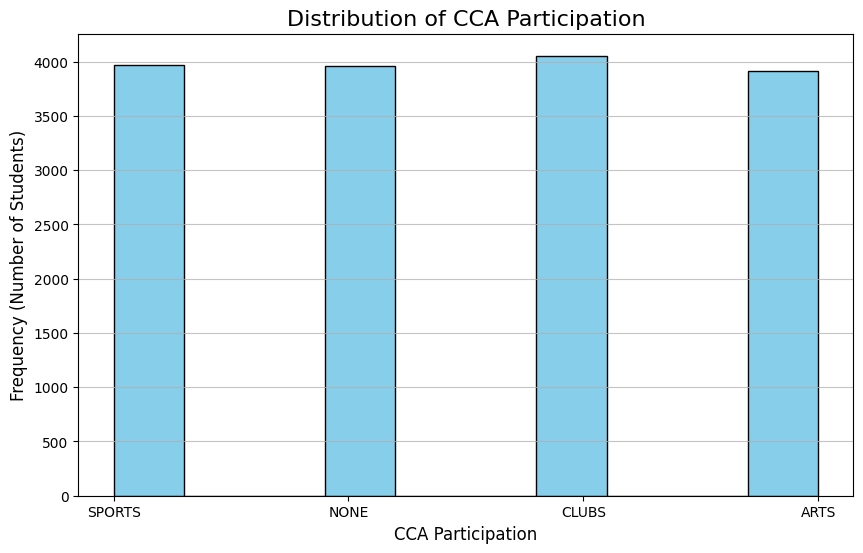

In [29]:
# 2. Create the histogram using Matplotlib
plt.figure(figsize=(10, 6)) # Set the figure size for better readability

plt.hist(
    df['CCA'], 
    bins=10,          # You can adjust the number of bins to see more or less detail
    color='skyblue',  # Set the color of the bars
    edgecolor='black' # Add black edges to bars for better separation
)

# 3. Add labels and a title for clarity
plt.title('Distribution of CCA Participation', fontsize=16)
plt.xlabel('CCA Participation', fontsize=12)
plt.ylabel('Frequency (Number of Students)', fontsize=12)
plt.grid(axis='y', alpha=0.75) # Add a grid for the y-axis

# SDave the plot
plt.savefig(PLOT_PATH + "bar_chart_CCA.png")

# 4. Display the plot
plt.show()


#### Analysis notes

The initial dataset has about 25% of observationds having missing values.

### Histogram of `final_test'

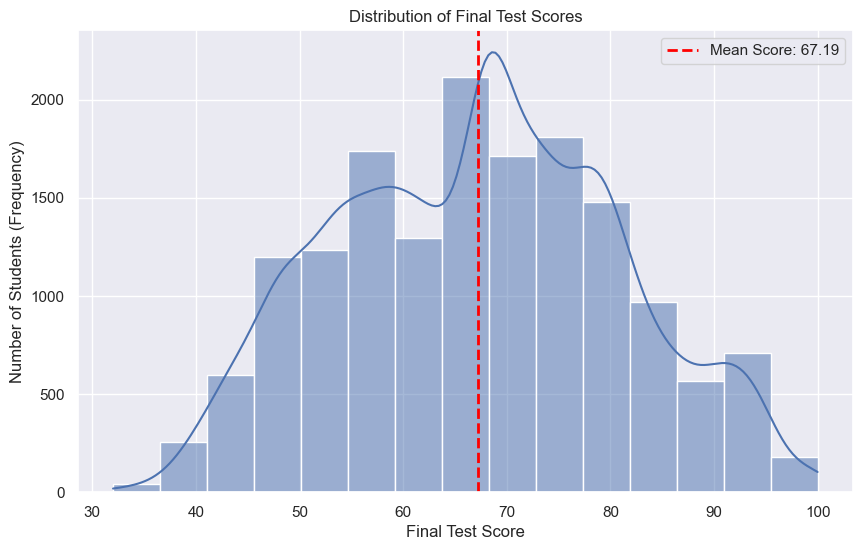

In [30]:
# Set a visually appealing style for the plot
sns.set_theme(style="darkgrid")

# Create a figure and axes for the plot. This allows for size adjustments.
plt.figure(figsize=(10, 6))

# Generate the histogram using seaborn's histplot
# 'kde=True' adds a smooth line to estimate the distribution's shape
ax = sns.histplot(data=df, x='final_test', bins=15, kde=True)  ## color='skyblue')

# --- 3. Customizing the Plot ---

# Add a title and labels for clarity and professionalism
ax.set_title('Distribution of Final Test Scores') ## , fontsize=18, pad=20)
ax.set_xlabel('Final Test Score')  ##, fontsize=14)
ax.set_ylabel('Number of Students (Frequency)') ##, fontsize=14)

# You can even add a vertical line for the mean score
mean_score = df['final_test'].mean()
ax.axvline(mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean Score: {mean_score:.2f}')
ax.legend() # Display the label for the mean line

plt.savefig(PLOT_PATH + 'histogram_CCA.png')

# Display the final plot
plt.show()

### Boxplot of `attendance_rate` and `final_test`

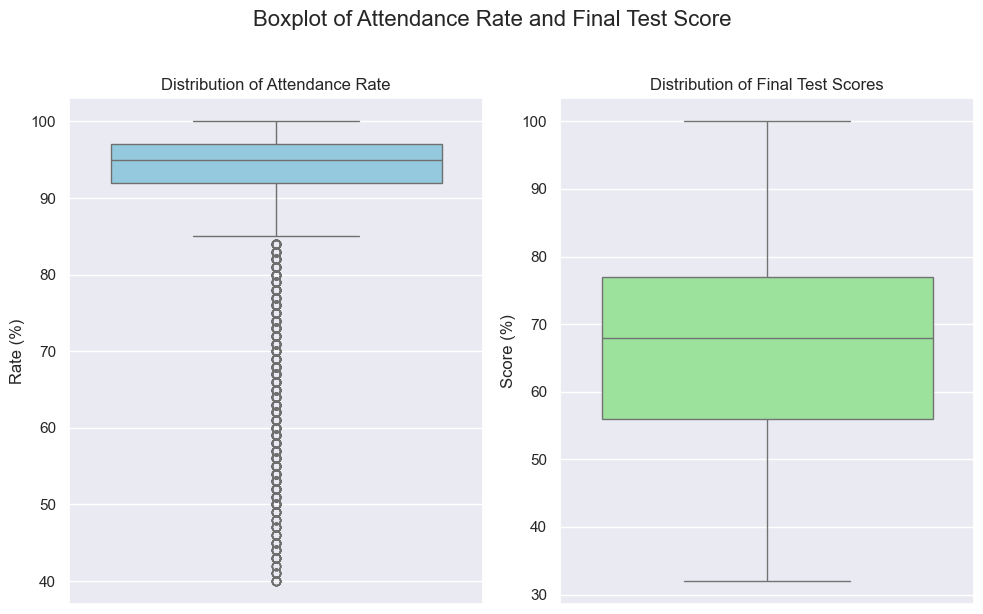

In [31]:
# Set the style for a cleaner look
sns.set_style("darkgrid")

# Create a figure and a set of subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot for Attendance Rate
sns.boxplot(ax=axes[0], y=df['attendance_rate'], color='skyblue')
axes[0].set_title('Distribution of Attendance Rate') ##, fontsize=14)
axes[0].set_ylabel('Rate (%)')
axes[0].set_xlabel('') # Hide x-axis label as it's not needed

# Plot for Final Test
sns.boxplot(ax=axes[1], y=df['final_test'], color='lightgreen')
axes[1].set_title('Distribution of Final Test Scores')  ##, fontsize=14)
axes[1].set_ylabel('Score (%)')
axes[1].set_xlabel('') # Hide x-axis label

# Add a main title for the entire figure
plt.suptitle('Boxplot of Attendance Rate and Final Test Score', fontsize=16, y=1.02)

# Adjust layout to prevent titles from overlapping
plt.tight_layout()

plt.savefig(PLOT_PATH + 'boxplot.png')

# Display the plot
plt.show()

From the above charts, there are a number of outliers in the attendance rate, but not for the marks for the Mathematics test. I will investigate on the quantum of students whose attendance is lower than the lower bound of the boxplot and whether there is any correlation with their final marks.

#### Investigate the `attendance_rate` column

In [32]:
# Define the column under investigation
col = 'attendance_rate'

# print(df[col].quantile(0.25))
# print(df[col].quantile(0.75))

# Calculate the Interquartile Range
iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
# print(iqr)
# Calculate the lower bound of the distribution
lower_bound = df[col].quantile(0.25) - (1.5 * iqr)
# print(lower_bound)

print(f"Total number of students whose attendance rate is below the lower bound: {len(df[df[col] < lower_bound]):,}")

Total number of students whose attendance rate is below the lower bound: 848


### Barchart of `age` column

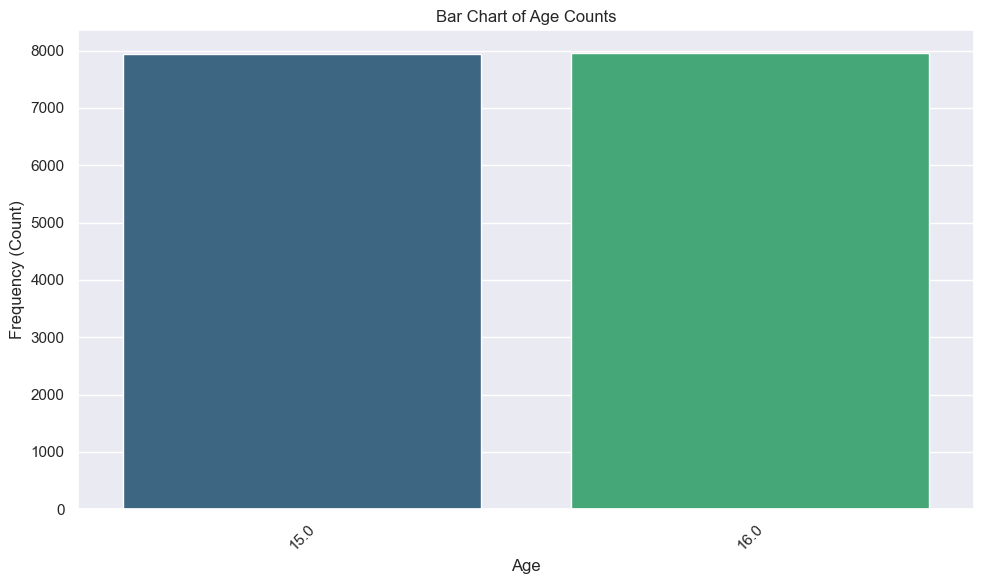

In [33]:
# Count the frequency of each unique age using value_counts() to create a Series
age_counts = df['age'].value_counts().sort_index()

# --- 2. Create the Bar Chart from the counts ---
sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))

# Use sns.barplot on the counted data
ax = sns.barplot(x=age_counts.index, y=age_counts.values, palette='viridis')

# --- Add Titles and Labels ---
ax.set_title('Bar Chart of Age Counts')  ##, fontsize=16)
ax.set_xlabel('Age')  ##, fontsize=12)
ax.set_ylabel('Frequency (Count)')  ##, fontsize=12)

# Improve readability of x-axis labels if there are many ages
plt.xticks(rotation=45)  ##, ha='right')
plt.tight_layout() # Adjust layout to make room for rotated labels

plt.savefig(PLOT_PATH + 'barchart')

# Display the plot
plt.show()

The students age are equally balanced for 15 and 16 years. 

### Breakdown of Students' Age by Gender

In [34]:
# Creating a cross tabular data for age and gender columns
age_gender_crosstab = pd.crosstab(index = df['age'],
                                  columns = df['gender'])

print(age_gender_crosstab)

gender  Female  Male
age                 
15.0      3969  3978
16.0      3947  4006


### Analysis of `hours_per_week`

In [35]:
df['hours_per_week'].describe()

count    15900.000000
mean        10.312579
std          4.461861
min          0.000000
25%          7.000000
50%          9.000000
75%         14.000000
max         20.000000
Name: hours_per_week, dtype: float64

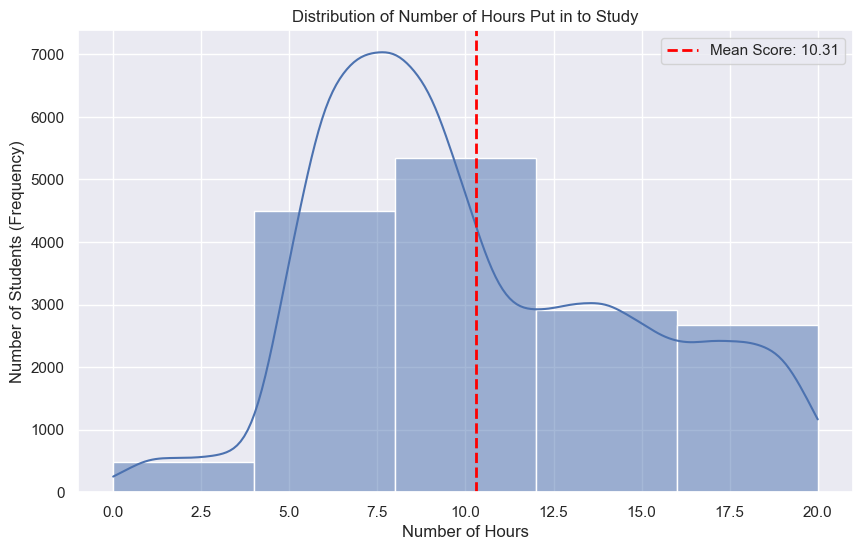

In [36]:
# Set a visually appealing style for the plot
sns.set_theme(style="darkgrid")

# Create a figure and axes for the plot. This allows for size adjustments.
plt.figure(figsize=(10, 6))

# Generate the histogram using seaborn's histplot
# 'kde=True' adds a smooth line to estimate the distribution's shape
ax = sns.histplot(data=df, x='hours_per_week', bins=5, kde=True)  ## color='skyblue')

# --- 3. Customizing the Plot ---

# Add a title and labels for clarity and professionalism
ax.set_title('Distribution of Number of Hours Put in to Study') ## , fontsize=18, pad=20)
ax.set_xlabel('Number of Hours')  ##, fontsize=14)
ax.set_ylabel('Number of Students (Frequency)') ##, fontsize=14)

# You can even add a vertical line for the mean score
mean_score = df['hours_per_week'].mean()
ax.axvline(mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean Score: {mean_score:.2f}')
ax.legend() # Display the label for the mean line

plt.savefig(PLOT_PATH + 'histogram_hrs_per_week.png')

# Display the final plot
plt.show()

## Correlation Analysis

### Creating a correlation

In [37]:
# Create a correlation matrix
corr_matrix = df[['hours_per_week', 'attendance_rate', 'sleep_minutes', 'final_test']].corr()

print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                 hours_per_week  attendance_rate  sleep_minutes  final_test
hours_per_week         1.000000         0.139817       0.123569   -0.145954
attendance_rate        0.139817         1.000000       0.867934    0.334937
sleep_minutes          0.123569         0.867934       1.000000    0.322292
final_test            -0.145954         0.334937       0.322292    1.000000


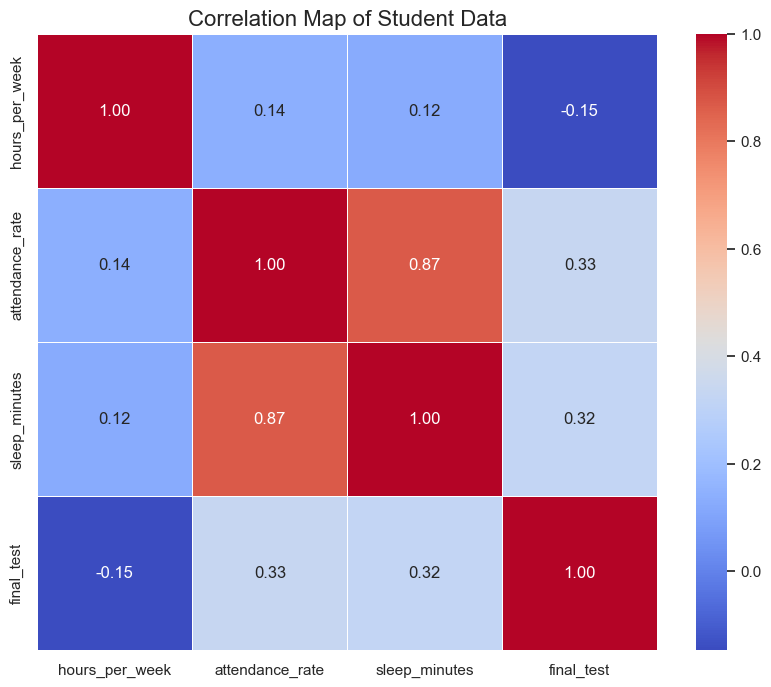

In [38]:
# Set the plot style
sns.set_style('darkgrid')

# Plot the correlation map (heatmap)
plt.figure(figsize=(10, 8)) # Set the size of the figure
sns.heatmap(
    corr_matrix, 
    annot=True,          # Annotate the values in the cells
    cmap='coolwarm',     # Choose a color map
    fmt=".2f",           # Format the annotations to two decimal places
    linewidths=.5        # Add lines between cells
)

plt.title('Correlation Map of Student Data', fontsize=16)

plt.savefig(PLOT_PATH + 'heatmap_test_sleep_attendance_study_hrs.png')
plt.show()


From the heatmap above, the features `'sleep_minutes'` and `'attendance_rate'` are highly correlated at 0.87. As such, I will drop the column `'sleep_minutes'` from the model.

#### Dropping the feature `sleep_minutes`

In [39]:
df.drop(columns = ['sleep_minutes'], inplace = True)

## Feature Engineering

### Feature/Target Separation